# Librerías utilizadas

In [1]:
# pip install pandas
# pip install matplotlib
# pip install networkx
# pip install python-dotenv
# pip install openai==0.28

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import openai
import os
from dotenv import load_dotenv, find_dotenv

# Creación del grafo

Leemos los datos del dataset de PrimeKG y representamos un subgrafo de las relaciones para el cáncer de mama.

In [3]:
primekg = pd.read_csv('kg.csv', low_memory = False)
primekg.head()

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


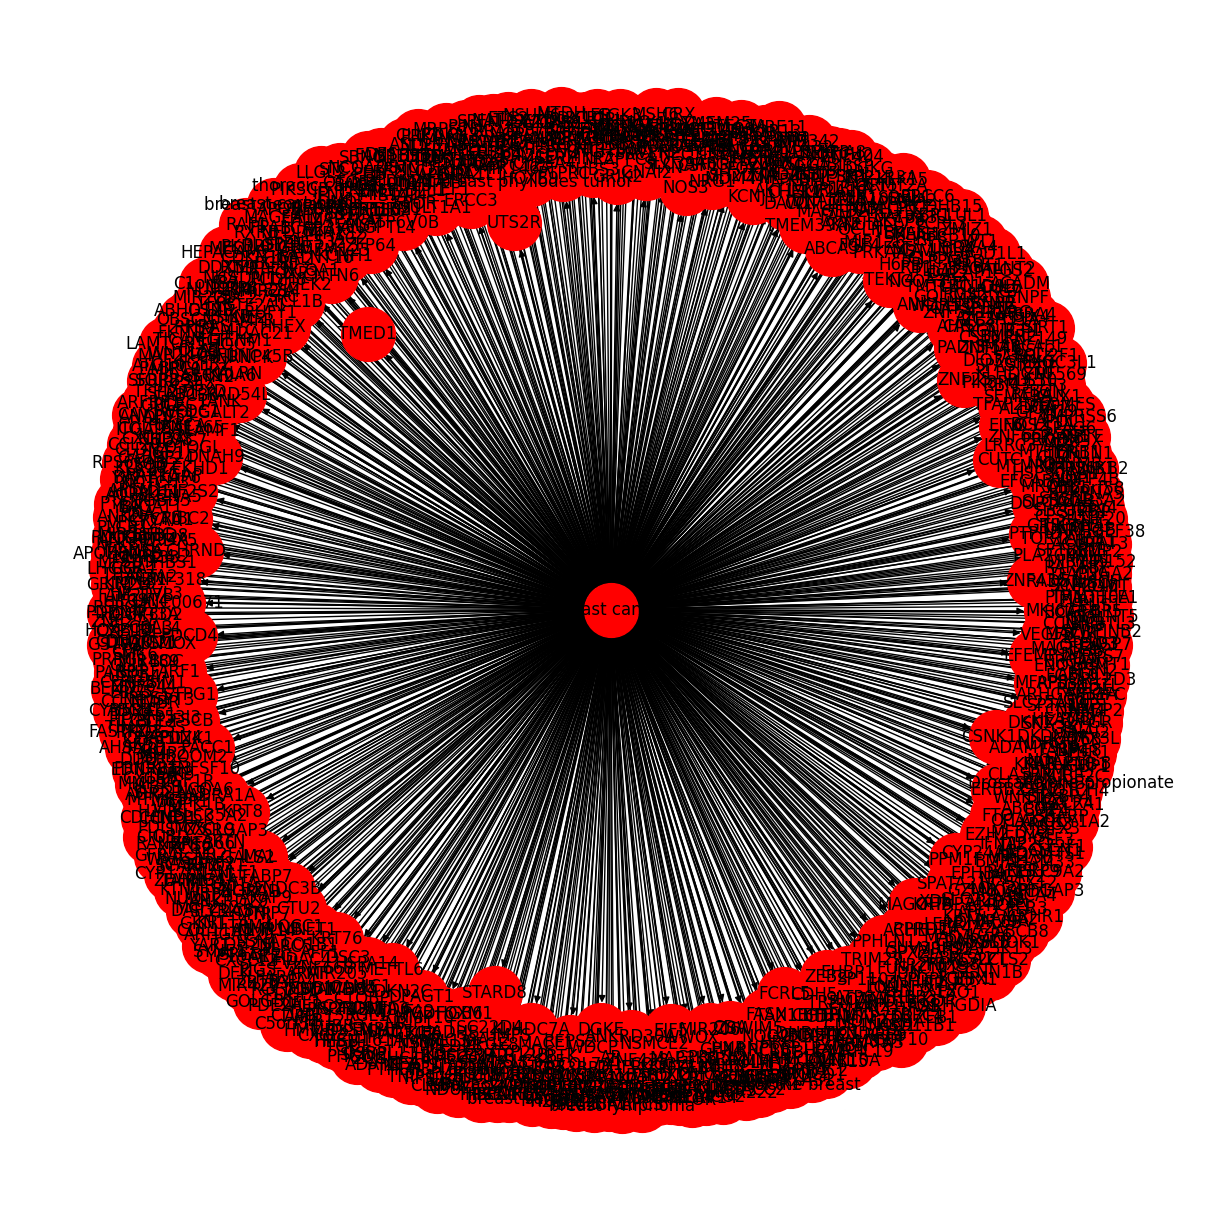

In [4]:
G = nx.from_pandas_edgelist(primekg[primekg['x_name'] == "breast cancer"], "x_name", "y_name", edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels = True, node_color = 'red', node_size = 1500, edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

Observamos que el grafo obtenido con PrimeKG es muy grande, por lo que lo simplificaremos restringiéndonos a la ontología MONDO, centrada en enfermedades y síntomas.

In [5]:
mondokg = primekg[(primekg['x_source'].str.contains('MONDO')) & (primekg['y_source'].str.contains('MONDO'))]
mondokg.head()

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
3315993,disease_disease,parent-child,35428,2816,disease,adrenal cortex disease,MONDO,38666,4,disease,adrenocortical insufficiency,MONDO
3315994,disease_disease,parent-child,35429,21034,disease,genetic alopecia,MONDO,38135,5,disease,"alopecia, isolated",MONDO
3315995,disease_disease,parent-child,35430,2243,disease,hemorrhagic disease,MONDO,38429,9,disease,"inherited bleeding disorder, platelet-type",MONDO
3315996,disease_disease,parent-child,35431,2245,disease,blood platelet disease,MONDO,38429,9,disease,"inherited bleeding disorder, platelet-type",MONDO
3315997,disease_disease,parent-child,35432,3847,disease,Mendelian disease,MONDO,38429,9,disease,"inherited bleeding disorder, platelet-type",MONDO


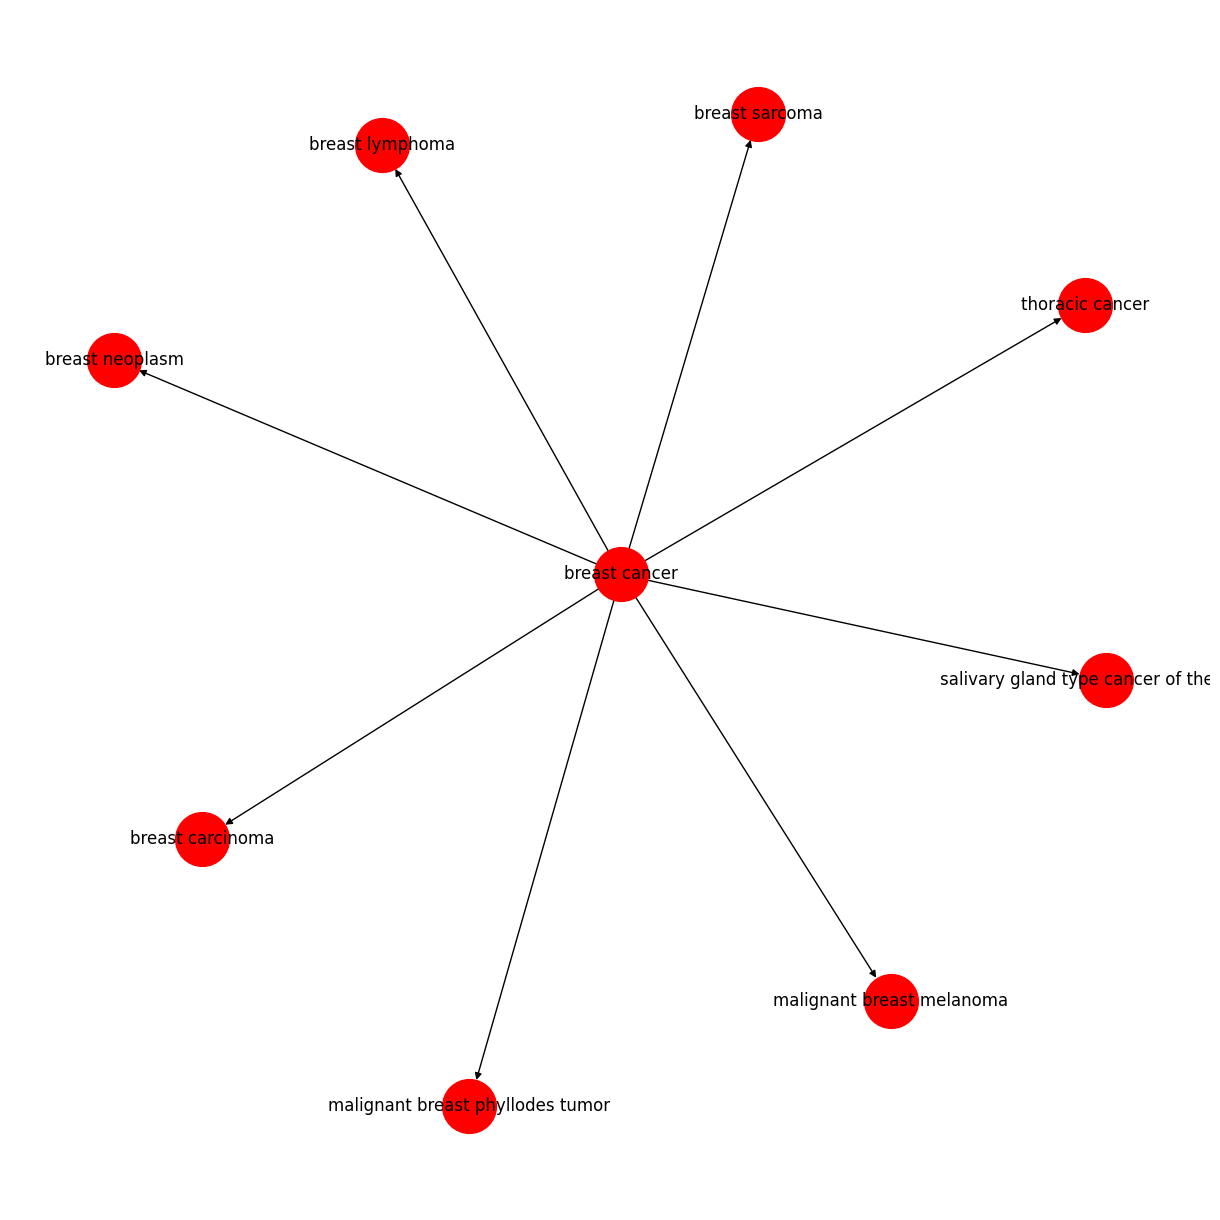

In [6]:
G = nx.from_pandas_edgelist(mondokg[mondokg['x_name'] == "breast cancer"], "x_name", "y_name", edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels = True, node_color = 'red', node_size = 1500, edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

Extraemos los nombres de cada par de entidades relacionadas en ambos dataframes.

In [7]:
nodosprime=primekg.loc[:, ['x_name', 'y_name']]
nodosprime.head()

,x_name,y_name
0,PHYHIP,KIF15
1,GPANK1,PNMA1
2,ZRSR2,TTC33
3,NRF1,MAN1B1
4,PI4KA,RGS20


In [8]:
nodosmondo = mondokg.loc[:, ['x_name', 'y_name']]
nodosmondo.head()

,x_name,y_name
3315993,adrenal cortex disease,adrenocortical insufficiency
3315994,genetic alopecia,"alopecia, isolated"
3315995,hemorrhagic disease,"inherited bleeding disorder, platelet-type"
3315996,blood platelet disease,"inherited bleeding disorder, platelet-type"
3315997,Mendelian disease,"inherited bleeding disorder, platelet-type"


Y, a continuación, creamos un grafo para cada dataframe con la librería "networkx", que contendrá únicamente la estructura de relaciones entre los nodos, sin ninguna información adicional como el tipo de relación. Si necesitamos dicha información, emplearemos los dataframes originales.

In [9]:
graphprime = nx.Graph() # Este grafo tarda unos 12 minutos en crearse y su uso es opcional, por restringirnos a la ontología MONDO, pero puede emplearse
                    # para estudiar otro tipo de relaciones, como las interacciones entre genes o proteínas.

for ind, nods in nodosprime.iterrows():
    graphprime.add_edge(nods[0], nods[1])

In [10]:
graphmondo = nx.Graph() # Este grafo, basado en MONDO, será el que usamos por defecto en todo el cuaderno, pero puede cambiarse por el grafo de PrimeKG
                        # introduciéndolo como argumento opcional en cualquier función.

for ind, nods in nodosmondo.iterrows():
    graphmondo.add_edge(nods[0], nods[1])

# Funciones

En esta sección crearemos funciones que nos servirán para explorar los grafos más profundamente.

La primera función que creamos sirve para encontrar el camino más corto entre dos nodos cualesquiera, siempre que exista tal relación.

In [11]:
def camino(source, target, graph = graphmondo):
    text = """"""
    if nx.has_path(graph, source, target):
        path = nx.shortest_path(graph, source, target)
        text += "The shortest path between {} and {} is {}".format(source, target, path)
    else: 
        text += "No relation found between {} and {}".format(source, target)
    return(path, text)

In [12]:
camino('lung cancer', 'skin cancer')

(['lung cancer',
  'lung carcinoma',
  'carcinoma',
  'skin carcinoma',
  'skin cancer'],
 "The shortest path between lung cancer and skin cancer is ['lung cancer', 'lung carcinoma', 'carcinoma', 'skin carcinoma', 'skin cancer']")

Otra posibilidad es la de buscar un camino específico que incluya un tercer nodo intermedio.

In [13]:
def multicamino(source, intermediate, target, graph = graphmondo):
    text = """"""
    [p1, t1] = camino(source, intermediate, graph)
    [p2, t2] = camino(intermediate, target, graph)
    path = p1+p2[1:]
    text += "The shortest path between {} and {}, passing through {}, is {}".format(source, target, intermediate, path)
    return(path, text)

In [14]:
multicamino('skin cancer', 'cancer', 'lung cancer')

(['skin cancer',
  'integumentary system cancer',
  'cancer',
  'respiratory system cancer',
  'lung cancer'],
 "The shortest path between skin cancer and lung cancer, passing through cancer, is ['skin cancer', 'integumentary system cancer', 'cancer', 'respiratory system cancer', 'lung cancer']")

Para poder evaluar la diferencia que causa en los resultados el número de caminos que le proporcionemos al LLM, crearemos funciones análogas a las dos anteriores que nos devuelvan todos los caminos de longitud mínima.

In [15]:
def caminos(source, target, graph = graphmondo):
    text = """"""
    if nx.has_path(graph, source, target):
        i = 1
        path = nx.all_shortest_paths(graph, source, target)
        path2 = nx.all_shortest_paths(graph, source, target)
        for p in path:
            text += "Path number {} between {} and {} is {}. ".format(i, source, target, p)
            i += 1
    else: 
        text += "No relation found between {} and {}".format(source, target)
    return(path2, text)

In [16]:
caminos('lung cancer', 'skin cancer')

(<generator object _build_paths_from_predecessors at 0x000001F182C78B30>,
 "Path number 1 between lung cancer and skin cancer is ['lung cancer', 'lung meningioma', 'meningioma (disease)', 'skin meningioma', 'skin cancer']. Path number 2 between lung cancer and skin cancer is ['lung cancer', 'lung meningioma', 'malignant tumor of meninges', 'skin meningioma', 'skin cancer']. Path number 3 between lung cancer and skin cancer is ['lung cancer', 'lung carcinoma', 'carcinoma', 'skin carcinoma', 'skin cancer']. Path number 4 between lung cancer and skin cancer is ['lung cancer', 'respiratory system cancer', 'cancer', 'integumentary system cancer', 'skin cancer']. Path number 5 between lung cancer and skin cancer is ['lung cancer', 'thoracic cancer', 'cancer', 'integumentary system cancer', 'skin cancer']. ")

In [17]:
def multicaminos(source, intermediate, target, graph = graphmondo):
    text = """"""
    [cam1, t1] = caminos(source, intermediate, graph)
    [cam2, t2] = caminos(intermediate, target, graph)
    cam1 = [c for c in cam1]
    cam2 = [c for c in cam2]
    paths = []

    for p1 in cam1:
        for p2 in cam2:
            paths.append(p1+p2[1:])

    i = 1
    for p in paths:
        text += "Path number {} between {} and {}, passing through {}, is {}. ".format(i, source, target, intermediate, p)
        i += 1

    return(paths, text)

In [18]:
multicaminos('skin cancer', 'cancer', 'lung cancer')

([['skin cancer',
   'integumentary system cancer',
   'cancer',
   'respiratory system cancer',
   'lung cancer'],
  ['skin cancer',
   'integumentary system cancer',
   'cancer',
   'thoracic cancer',
   'lung cancer']],
 "Path number 1 between skin cancer and lung cancer, passing through cancer, is ['skin cancer', 'integumentary system cancer', 'cancer', 'respiratory system cancer', 'lung cancer']. Path number 2 between skin cancer and lung cancer, passing through cancer, is ['skin cancer', 'integumentary system cancer', 'cancer', 'thoracic cancer', 'lung cancer']. ")

## Representación de los grafos

Una herramienta que nos ayudará a entender los resultados obtenidos de las funciones que acabamos de definir será la representación de los subgrafos extraídos.

In [19]:
def grafo(source, target, graph = graphmondo, kg = mondokg):
    [path, t] = camino(source, target, graph)
    d = {}
    G = nx.Graph()
    for i in range(len(path)-1):
        quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
        for row in quer.iterrows():
            G.add_edge(row[1]['x_name'], row[1]['y_name'])
            d[(str(row[1]['x_name']), str(row[1]['y_name']))] = row[1]['display_relation']
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_color = 'lightblue')    
    nx.draw_networkx_edge_labels(G, pos, edge_labels = d, font_color = 'red')

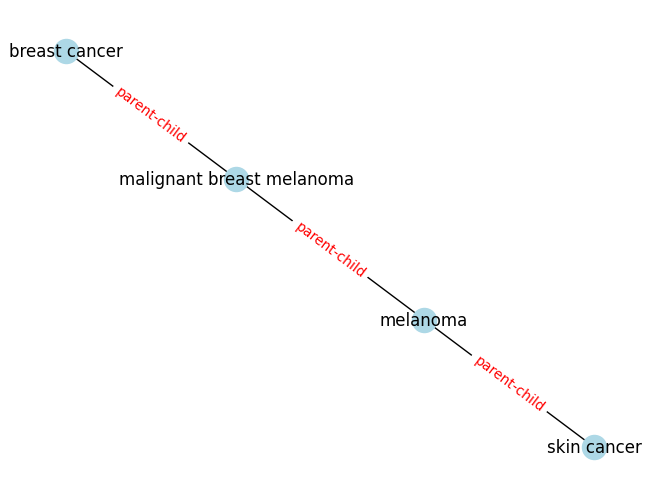

In [20]:
grafo('skin cancer', 'breast cancer')

In [21]:
def multigrafo(source, intermediate, target, graph = graphmondo, kg = mondokg):
    [cam1, t1] = camino(source, intermediate, graph)
    [cam2, t2] = camino(intermediate, target, graph)
    path = (cam1+cam2[1:])
    d = {}
    G = nx.Graph()
    for i in range(len(path)-1):
        quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
        for row in quer.iterrows():
            G.add_edge(row[1]['x_name'], row[1]['y_name'])
            d[(str(row[1]['x_name']), str(row[1]['y_name']))] = row[1]['display_relation']
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_color = 'lightblue')    
    nx.draw_networkx_edge_labels(G, pos, edge_labels = d, font_color = 'red')
        

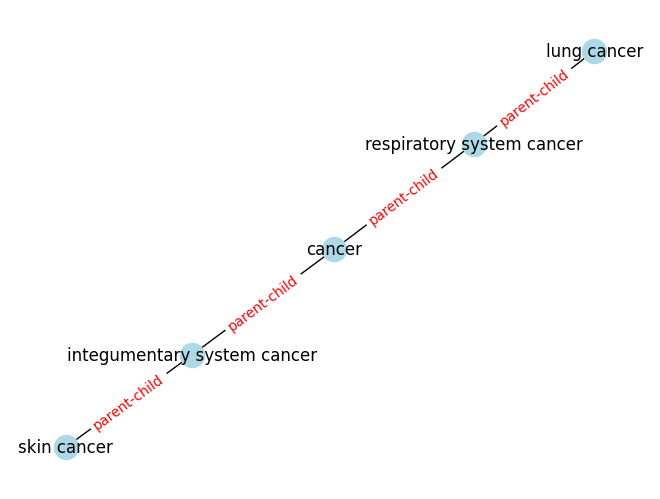

In [22]:
multigrafo('skin cancer', 'cancer', 'lung cancer')

In [23]:
def grafos(source, target, graph = graphmondo, kg = mondokg):
    [paths, t] = caminos(source, target, graph)
    G = nx.Graph()
    paths = [path for path in paths]
    d = {}

    G.add_node(source, pos = (0, 0))
    G.add_node(target, pos = (10, 10))

    i = 0
    num_paths = len(paths)
    if (num_paths == 1):
        num_paths = 3
        i = 1
    for path in paths:
        nodes_per_path = len(path)
        previous_node = source
        j = 1
        for node in path[1:-1]:
            new_node = '{}'.format(node)
            G.add_node(new_node, pos = (i*10/(num_paths-1), j*10/(nodes_per_path-1)))
            G.add_edge(previous_node, new_node)
            previous_node = new_node
            j += 1
        G.add_edge(previous_node, target)
        i += 1
        for k in range(len(path)-1):
            quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[k], path[k+1], path[k+1], path[k]))
            for row in quer.iterrows():
                G.add_edge(row[1]['x_name'], row[1]['y_name'])
                d[(str(row[1]['x_name']), str(row[1]['y_name']))] = row[1]['display_relation']
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels = True, node_size = 500, node_color = 'lightblue', font_size = 6, edge_color = 'gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = d, font_color = 'red', font_size = 6, rotate = False)
    plt.show()

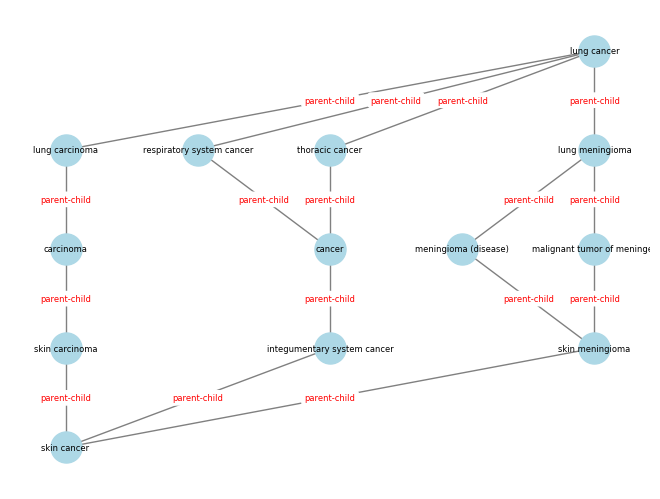

In [24]:
grafos('skin cancer', 'lung cancer')

In [25]:
def multigrafos(source, intermediate, target, graph = graphmondo, kg = mondokg):
    [cam1, t1] = caminos(source, intermediate, graph)
    [cam2, t2] = caminos(intermediate, target, graph)
    cam1 = [c for c in cam1]
    cam2 = [c for c in cam2]
    paths = []

    for p1 in cam1:
        for p2 in cam2:
            paths.append(p1+p2[1:])
    
    G = nx.Graph()
    d = {}

    G.add_node(source, pos = (0, 0))
    G.add_node(target, pos = (10, 10))

    i = 0
    num_paths = len(paths)
    if (num_paths == 1):
        num_paths = 3
        i = 1
    for path in paths:
        path = [pa for pa in path]
        nodes_per_path = len(path)
        previous_node = source
        j = 1
        for node in path[1:-1]:
            new_node = '{}'.format(node)
            G.add_node(new_node, pos = (i*10/(num_paths-1), j*10/(nodes_per_path-1)))
            G.add_edge(previous_node, new_node)
            previous_node = new_node
            j += 1
        G.add_edge(previous_node, target)
        i += 1
        for k in range(len(path)-1):
            quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[k], path[k+1], path[k+1], path[k]))
            for row in quer.iterrows():
                G.add_edge(row[1]['x_name'], row[1]['y_name'])
                d[(str(row[1]['x_name']), str(row[1]['y_name']))] = row[1]['display_relation']
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels = True, node_size = 500, node_color = 'lightblue', font_size = 6, edge_color = 'gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = d, font_color = 'red', font_size = 6, rotate = False)
    plt.show()

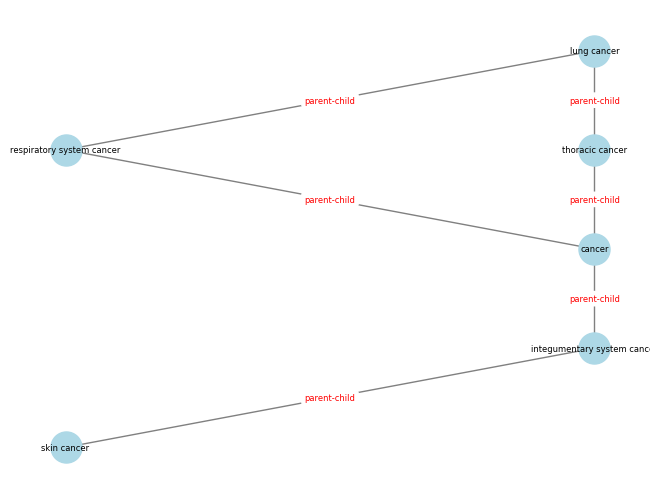

In [26]:
multigrafos('skin cancer', 'cancer', 'lung cancer')

## Formateado de caminos

El último paso antes de implementar el LLM será formatear los caminos extraídos del grafo de forma consistente, por lo que crearemos una función para definir el formato de las salidas de cada una de las funciones de extracción de caminos.

In [27]:
def relacion(source, target, graph = graphmondo, kg = mondokg):
    text = """"""
    [path, t] = camino(source, target, graph)
    text += t
    for i in range(len(path)-1):
        quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
        for row in quer.iterrows():
            text += """ {} -- {} -> {}.""".format(path[i], row[1]['display_relation'], path[i+1])
            break
    return(text)

In [28]:
relacion('autism spectrum disorder', 'breast cancer')

"The shortest path between autism spectrum disorder and breast cancer is ['autism spectrum disorder', 'Asperger syndrome', 'genetic nervous system disorder', 'Mendelian disease', 'hereditary breast carcinoma', 'breast carcinoma', 'breast cancer'] autism spectrum disorder -- parent-child -> Asperger syndrome. Asperger syndrome -- parent-child -> genetic nervous system disorder. genetic nervous system disorder -- parent-child -> Mendelian disease. Mendelian disease -- parent-child -> hereditary breast carcinoma. hereditary breast carcinoma -- parent-child -> breast carcinoma. breast carcinoma -- parent-child -> breast cancer."

In [29]:
def multirelacion(source, intermediate, target, graph = graphmondo, kg = mondokg):
    text = """"""
    [path, t] = multicamino(source, intermediate, target, graph)
    text += t
    for i in range(len(path)-1):
        quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
        for row in quer.iterrows():
            text += """ {} -- {} -> {}.""".format(path[i], row[1]['display_relation'], path[i+1])
            break
    return(text)

In [30]:
multirelacion('skin cancer', 'cancer', 'lung cancer')

"The shortest path between skin cancer and lung cancer, passing through cancer, is ['skin cancer', 'integumentary system cancer', 'cancer', 'respiratory system cancer', 'lung cancer'] skin cancer -- parent-child -> integumentary system cancer. integumentary system cancer -- parent-child -> cancer. cancer -- parent-child -> respiratory system cancer. respiratory system cancer -- parent-child -> lung cancer."

In [31]:
def relaciones(source, target, graph = graphmondo, kg = mondokg):
    text = """"""
    [paths, t]=caminos(source, target, graph)
    j = 1
    for path in paths:
        text += """ Path {} between {} and {} is {}""".format(j, source, target, path)
        for i in range(len(path)-1):
            quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
            for row in quer.iterrows():
                text += """ {} -- {} -> {}.""".format(path[i], row[1]['display_relation'], path[i+1])
                break
        j += 1
    return(text)

In [32]:
relaciones('skin cancer', 'lung cancer')

" Path 1 between skin cancer and lung cancer is ['skin cancer', 'skin carcinoma', 'carcinoma', 'lung carcinoma', 'lung cancer'] skin cancer -- parent-child -> skin carcinoma. skin carcinoma -- parent-child -> carcinoma. carcinoma -- parent-child -> lung carcinoma. lung carcinoma -- parent-child -> lung cancer. Path 2 between skin cancer and lung cancer is ['skin cancer', 'integumentary system cancer', 'cancer', 'respiratory system cancer', 'lung cancer'] skin cancer -- parent-child -> integumentary system cancer. integumentary system cancer -- parent-child -> cancer. cancer -- parent-child -> respiratory system cancer. respiratory system cancer -- parent-child -> lung cancer. Path 3 between skin cancer and lung cancer is ['skin cancer', 'integumentary system cancer', 'cancer', 'thoracic cancer', 'lung cancer'] skin cancer -- parent-child -> integumentary system cancer. integumentary system cancer -- parent-child -> cancer. cancer -- parent-child -> thoracic cancer. thoracic cancer -- p

In [33]:
def multirelaciones(source, intermediate, target, graph = graphmondo, kg = mondokg):
    text = """"""
    [paths, t]=multicaminos(source, intermediate, target, graph)
    j = 1
    for path in paths:
        text += """ Path {} between {} and {} is {}""".format(j, source, target, path)
        for i in range(len(path)-1):
            quer = kg.query('(x_name=="{}"&y_name=="{}")|(x_name=="{}"&y_name=="{}")'.format(path[i], path[i+1], path[i+1], path[i]))
            for row in quer.iterrows():
                text += """ {} -- {} -> {}.""".format(path[i], row[1]['display_relation'], path[i+1])
                break
        j += 1
    return(text)

In [34]:
multirelaciones('skin cancer', 'cancer', 'lung cancer')

" Path 1 between skin cancer and lung cancer is ['skin cancer', 'integumentary system cancer', 'cancer', 'respiratory system cancer', 'lung cancer'] skin cancer -- parent-child -> integumentary system cancer. integumentary system cancer -- parent-child -> cancer. cancer -- parent-child -> respiratory system cancer. respiratory system cancer -- parent-child -> lung cancer. Path 2 between skin cancer and lung cancer is ['skin cancer', 'integumentary system cancer', 'cancer', 'thoracic cancer', 'lung cancer'] skin cancer -- parent-child -> integumentary system cancer. integumentary system cancer -- parent-child -> cancer. cancer -- parent-child -> thoracic cancer. thoracic cancer -- parent-child -> lung cancer."

La siguiente función será de utilidad para encontrar los nombres de las enfermedades que busquemos en la ontología.

In [35]:
def find(text, kg = mondokg):
    display(kg[(kg['x_name'].str.contains(text)) | (kg['y_name'].str.contains(text))])

In [36]:
find('diabetes')

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
3316011,disease_disease,parent-child,35439,20573,disease,inherited disease susceptibility,MONDO,94845,65_12963_12962_12966_12969_12970_11386_12971,disease,"microvascular complications of diabetes, susce...",MONDO_grouped
3322330,disease_disease,parent-child,35764,5240,disease,kidney disease,MONDO,38244,4782,disease,diabetes insipidus,MONDO
3322630,disease_disease,parent-child,36376,1933,disease,endocrine pancreas disease,MONDO,33575,5015,disease,diabetes mellitus (disease),MONDO
3322631,disease_disease,parent-child,36010,2908,disease,glucose metabolism disease,MONDO,33575,5015,disease,diabetes mellitus (disease),MONDO
3322837,disease_disease,parent-child,33575,5015,disease,diabetes mellitus (disease),MONDO,28552,11123_12919_7454_5147_10861_10862_10863_10864_...,disease,type 1 diabetes mellitus,MONDO_grouped
...,...,...,...,...,...,...,...,...,...,...,...,...
6060397,disease_disease,parent-child,29938,31481,disease,"microcephaly, epilepsy, and diabetes syndrome 1",MONDO,39784,100328,disease,"microcephaly, epilepsy, and diabetes syndrome",MONDO
6061934,disease_disease,parent-child,99988,100072,disease,"neonatal diabetes, congenital sensorineural he...",MONDO,36673,19589,disease,syndromic genetic deafness,MONDO
6062007,disease_disease,parent-child,27653,100164_16391,disease,permanent neonatal diabetes mellitus,MONDO_grouped,35515,19052,disease,inborn errors of metabolism,MONDO
6062008,disease_disease,parent-child,27654,20525_12522_30089_30088_11073_12480_30087_100165,disease,neonatal diabetes mellitus,MONDO_grouped,35458,6025,disease,autosomal recessive disease,MONDO


# Implementación de la API de OpenAI

Una vez completa la parte de extracción de información, solo faltará crear una instancia de ChatGPT que sustituya a la que se emplea en el proyecto InnovaTrial. Esto lo hacemos a través de la API de OpenAI, que nos permite acceder directamente a los modelos de ChatGPT desde nuestro código.

In [37]:
_ = load_dotenv(find_dotenv())

# openai.api_type = os.getenv('OPENAI_API_TYPE')
# openai.api_version = os.getenv('OPENAI_API_VERSION')
# openai.api_base = os.getenv('OPENAI_API_BASE')
openai.api_key = os.getenv('OPENAI_API_KEY')
# deployment_name = os.getenv('DEPLOYMENT_NAME')

In [38]:
def get_completion(prompt: str, model = "gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        # engine=deployment_name,
        model = model,
        messages = messages,
        temperature = 0,
    )
    return response.choices[0].message["content"]

Tras realizar pruebas con diferentes tipos de prompts, encontramos que las siguientes conseguían los resultados más coherentes y consistentes.

In [39]:
text = f"""Find a relationship between autism spectrum disorder and breast cancer"""


prompt = f"""
Your task is to perform the following actions:
1- Answer to the text delimited by triple backticks using natural language
2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

Use the following format:
Query: <query to answer>

-----------------------------------------------------------

NL answer: <natural language answer>
KG: <knowledge graph extracted from NL answer>

´´´{text}´´´
"""
response = get_completion(prompt)
print(response)

-----------------------------------------------------------

NL answer: There is no known direct relationship between autism spectrum disorder and breast cancer.

KG: autism spectrum disorder -- has_no_direct_relationship_with -> breast cancer


In [40]:
text = f"""Find a relationship between autism spectrum disorder and breast cancer"""
extra = f"""The shortest path between autism spectrum disorder and breast cancer is ['autism spectrum disorder', 'Asperger syndrome', 'genetic nervous system disorder', 'Mendelian disease', 'hereditary breast carcinoma', 'breast carcinoma', 'breast cancer']
autism spectrum disorder parent-child Asperger syndrome
Asperger syndrome parent-child genetic nervous system disorder
genetic nervous system disorder parent-child Mendelian disease
Mendelian disease parent-child hereditary breast carcinoma
hereditary breast carcinoma parent-child breast carcinoma
breast carcinoma parent-child breast cancer"""

prompt = f"""
Your task is to perform the following actions:
1- Answer to the text delimited by triple backticks using natural language giving context to the answer by using the extra info delimited by quadruple backticks. Use that information to create a complete answer, explaining the relations between entities, but don´t just paraphrase it.
2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

Use the following format:
Query: <query to answer>

-----------------------------------------------------------

NL answer plus: <NL enhanced by additional information>
KG plus: <knowledge graph extracted from NL answer plus using additional information>

´´´{text}´´´

´´´´{extra}´´´´
"""
response = get_completion(prompt)
print(response)

Query: Find a relationship between autism spectrum disorder and breast cancer

-----------------------------------------------------------

NL answer plus: Autism spectrum disorder is related to breast cancer through a chain of connections: Asperger syndrome is a type of autism spectrum disorder, which is linked to genetic nervous system disorders. Genetic nervous system disorders can lead to Mendelian diseases, one of which is hereditary breast carcinoma. Hereditary breast carcinoma can progress to breast carcinoma, ultimately resulting in breast cancer.

KG plus: 
autism spectrum disorder -- parent-child --> Asperger syndrome
Asperger syndrome -- parent-child --> genetic nervous system disorder
genetic nervous system disorder -- parent-child --> Mendelian disease
Mendelian disease -- parent-child --> hereditary breast carcinoma
hereditary breast carcinoma -- parent-child --> breast carcinoma
breast carcinoma -- parent-child --> breast cancer


Teniendo esto en cuenta, creamos una función final para cada tipo de consulta que realice un proceso en varias partes: primero pide al LLM que responda a la consulta en lenguaje natural sin  emplear la información de la ontología, y después extraiga un grafo de conocimiento de dicha respuesta. A continuación, busca el camino o caminos relevantes en la ontología y se los pasa al LLM, que ahora utiliza esta información para dar una segunda respuesta a la consulta en lenguaje natural y extraer un grafo de la respuesta. Por último, representa gráficamente los caminos extraídos del grafo de conocimiento.

### Un camino

In [41]:
def gpt_un_camino(source, target, graph = graphmondo, kg = mondokg):
    
    grafo(source, target, graph, kg)   

    #Parte 1
    text = """Find a relationship between {} and {}""".format(source, target)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:
    Query: <query to answer>

    -----------------------------------------------------------

    NL answer: <natural language answer>
    KG: <knowledge graph extracted from NL answer>

    ´´´{text}´´´

    """
    response = get_completion(prompt)
    print(response)

    #Parte 2
    print('-----------------------------------------------------------')
    extra = """{}""".format(relacion(source, target, graph, kg))
    print(extra)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language giving a complete explanation on how the different entities from the info extracted from the knowledge graph interact between each other. To do that use your own knowledge, and don't just paraphrase the relations from the kg.
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:

    -----------------------------------------------------------

    NL answer plus: <NL enhanced by additional information>
    KG plus: <knowledge graph extracted from NL answer plus using additional information>

    ´´´{text}´´´

    ´´´´{extra}´´´´
    """
    response = get_completion(prompt)
    print(response)


Query: Find a relationship between breast cancer and skin cancer

-----------------------------------------------------------

NL answer: Both breast cancer and skin cancer are types of cancer that can occur in the human body.

KG: breast cancer -- type_of -> cancer
    skin cancer -- type_of -> cancer
-----------------------------------------------------------
The shortest path between breast cancer and skin cancer is ['breast cancer', 'malignant breast melanoma', 'melanoma', 'skin cancer'] breast cancer -- parent-child -> malignant breast melanoma. malignant breast melanoma -- parent-child -> melanoma. melanoma -- parent-child -> skin cancer.
-----------------------------------------------------------

NL answer plus: Breast cancer can lead to the development of malignant breast melanoma, which is a type of melanoma. Melanoma is a type of skin cancer, showing a progression from breast cancer to skin cancer through the development of malignant breast melanoma.

KG plus: breast cancer 

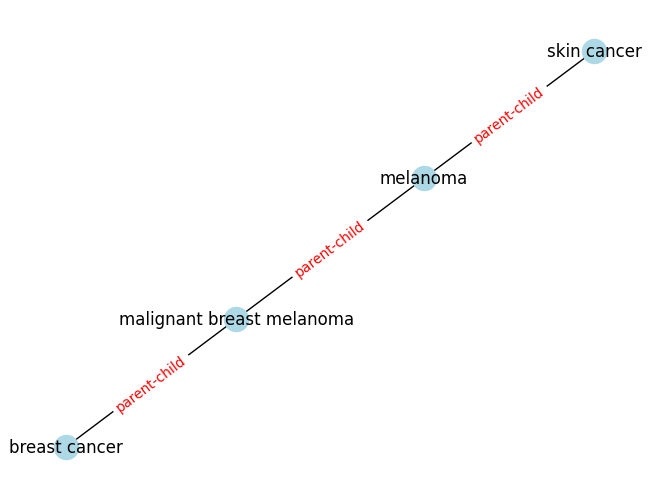

In [42]:
gpt_un_camino('breast cancer', 'skin cancer')

### Elemento intermedio (un camino)

In [43]:
def gpt_un_camino_int(source, intermediate, target, graph = graphmondo, kg = mondokg):
    
    multigrafo(source, intermediate, target, graph, kg)   

    #Parte 1
    text = """Find a relationship between {} and {} that involves {}""".format(source, target, intermediate)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:
    Query: <query to answer>

    -----------------------------------------------------------

    NL answer: <natural language answer>
    KG: <knowledge graph extracted from NL answer>

    ´´´{text}´´´

    """
    response = get_completion(prompt)
    print(response)

    #Parte 2
    print('-----------------------------------------------------------')
    extra = """{}""".format(multirelacion(source, intermediate, target, graph, kg))
    print(extra)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language giving a complete explanation on how the different entities from the info extracted from the knowledge graph interact between each other. To do that use your own knowledge, and don't just paraphrase the relations from the kg.
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:

    -----------------------------------------------------------

    NL answer plus: <NL enhanced by additional information>
    KG plus: <knowledge graph extracted from NL answer plus using additional information>

    ´´´{text}´´´

    ´´´´{extra}´´´´
    """
    response = get_completion(prompt)
    print(response)


Query: Find a relationship between congestive heart failure and pulmonary edema that involves acute respiratory distress syndrome

-----------------------------------------------------------

NL answer: Congestive heart failure can lead to pulmonary edema, which in turn can cause acute respiratory distress syndrome.

KG: congestive heart failure -- can lead to -> pulmonary edema -- can cause -> acute respiratory distress syndrome
-----------------------------------------------------------
The shortest path between congestive heart failure and pulmonary edema, passing through acute respiratory distress syndrome, is ['congestive heart failure', 'heart failure', 'cardio-renal syndrome', 'syndromic disease', 'acute respiratory distress syndrome', 'acute respiratory failure', 'pulmonary edema'] congestive heart failure -- parent-child -> heart failure. heart failure -- parent-child -> cardio-renal syndrome. cardio-renal syndrome -- parent-child -> syndromic disease. syndromic disease -- par

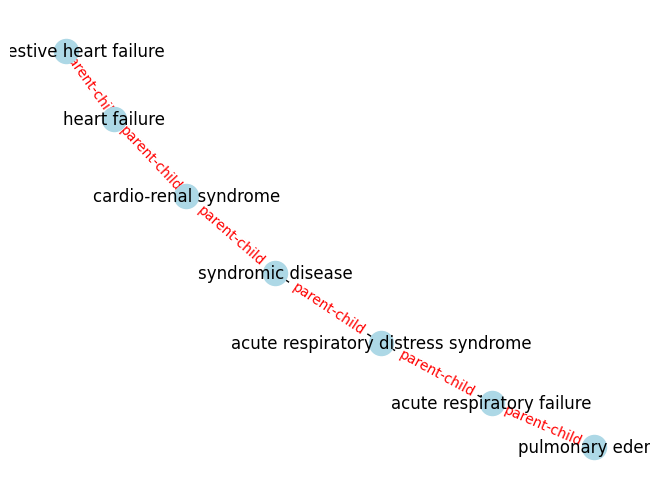

In [44]:
gpt_un_camino_int('congestive heart failure', 'acute respiratory distress syndrome', 'pulmonary edema')

### Múltiples caminos

In [45]:
def gpt_mult_caminos(source, target, graph = graphmondo, kg = mondokg):
    
    grafos(source, target, graph, kg)
    print('------------------------------------------------')

    #Parte 1
    text = """Find multiple relationships between {} and {}""".format(source, target)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:
    Query: <query to answer>

    -----------------------------------------------------------

    NL answer: <natural language answer>
    KG: <knowledge graph extracted from NL answer>

    ´´´{text}´´´

    """
    response = get_completion(prompt)
    print(response)

    #Parte 2
    print('-----------------------------------------------------------')
    extra = """{}""".format(relaciones(source, target, graph, kg))
    print(extra)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language giving a complete explanation on how the different entities from the info extracted from the knowledge graph interact between each other. To do that use your own knowledge, and don't just paraphrase the relations from the kg.
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:

    -----------------------------------------------------------

    NL answer plus: <NL enhanced by additional information>
    KG plus: <knowledge graph extracted from NL answer plus using additional information>

    ´´´{text}´´´

    ´´´´{extra}´´´´
    """
    response = get_completion(prompt)
    print(response)

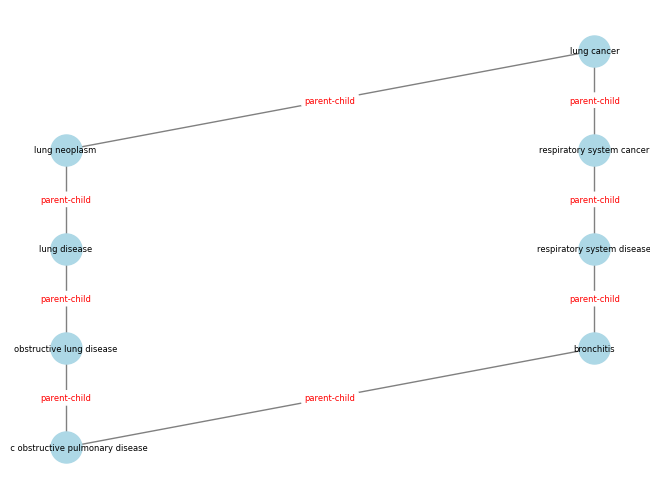

------------------------------------------------
Query: Find multiple relationships between chronic obstructive pulmonary disease and lung cancer

-----------------------------------------------------------

NL answer: Chronic obstructive pulmonary disease (COPD) and lung cancer are both respiratory diseases that can coexist in the same patient. COPD is a risk factor for developing lung cancer, and individuals with COPD have a higher likelihood of developing lung cancer compared to those without COPD. Smoking is a common risk factor for both COPD and lung cancer, further linking the two conditions.

KG: COPD -- coexist_with -> lung cancer
    COPD -- risk_factor_for -> lung cancer
    COPD -- higher_likelihood_of -> developing lung cancer
    COPD -- linked_by -> smoking
    lung cancer -- linked_by -> smoking
-----------------------------------------------------------
 Path 1 between chronic obstructive pulmonary disease and lung cancer is ['chronic obstructive pulmonary disease', 'ob

In [46]:
gpt_mult_caminos('chronic obstructive pulmonary disease', 'lung cancer')

### Elemento intermedio (múltiples caminos)

In [47]:
def gpt_mult_caminos_int(source, intermediate, target, graph = graphmondo, kg = mondokg):
    
    multigrafos(source, intermediate, target, graph, kg)
    print('------------------------------------------------')

    #Parte 1
    text = """Find multiple relationships between {} and {} that involve {}""".format(source, target, intermediate)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:
    Query: <query to answer>

    -----------------------------------------------------------

    NL answer: <natural language answer>
    KG: <knowledge graph extracted from NL answer>

    ´´´{text}´´´

    """
    response = get_completion(prompt)
    print(response)

    #Parte 2
    print('-----------------------------------------------------------')
    extra = """{}""".format(multirelaciones(source, intermediate, target, graph, kg))
    print(extra)

    prompt = f"""
    Your task is to perform the following actions:
    1- Answer to the text delimited by triple backticks using natural language giving a complete explanation on how the different entities from the info extracted from the knowledge graph interact between each other. To do that use your own knowledge, and don't just paraphrase the relations from the kg.
    2- Transform the answer from 1- into a knowledge graph using the following structure: a -- relation_ab -> b --...->n

    Use the following format:

    -----------------------------------------------------------

    NL answer plus: <NL enhanced by additional information>
    KG plus: <knowledge graph extracted from NL answer plus using additional information>

    ´´´{text}´´´

    ´´´´{extra}´´´´
    """
    response = get_completion(prompt)
    print(response)

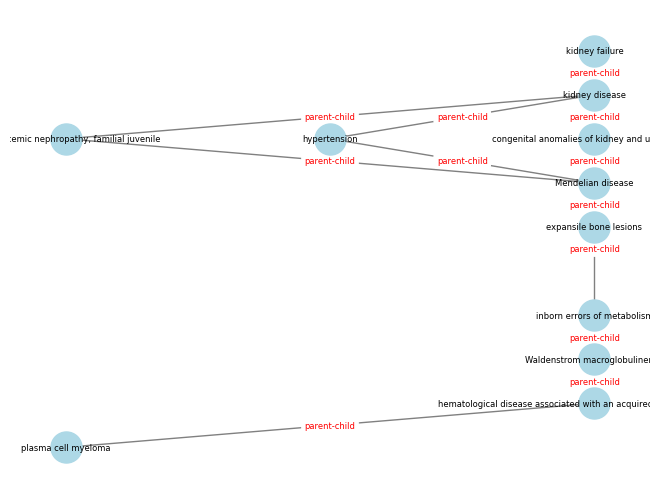

------------------------------------------------
Query: Find multiple relationships between plasma cell myeloma and kidney failure that involve expansile bone lesions

-----------------------------------------------------------

NL answer: Plasma cell myeloma can lead to kidney failure due to the production of abnormal proteins that can damage the kidneys. Additionally, expansile bone lesions are a common feature of plasma cell myeloma, which can further impact kidney function if they affect the bones surrounding the kidneys.

KG: plasma cell myeloma -- can lead to --> kidney failure
    plasma cell myeloma -- common feature --> expansile bone lesions
    expansile bone lesions -- can impact --> kidney function
-----------------------------------------------------------
 Path 1 between plasma cell myeloma and kidney failure is ['plasma cell myeloma', 'hematological disease associated with an acquired peripheral neuropathy', 'Waldenstrom macroglobulinemia', 'inborn errors of metabolism'

In [48]:
gpt_mult_caminos_int('plasma cell myeloma', 'expansile bone lesions', 'kidney failure')